# Modèles avancés (20%) 

In [58]:
from comet_ml import Experiment

In [59]:
from dotenv import load_dotenv
import os

In [60]:
load_dotenv(r"C:\Users\Prevot\Documents\Montreal\Cours\ScienceDesDonnees\Projet\A02-projet\notebooks\.env")

True

In [61]:
comet_api_key = os.environ.get('COMET_API_KEY')

In [62]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve
import pickle
import seaborn as sns

### 1. Classificateur XGBoost en utilisant uniquement les caractéristiques de distance et d'angle 

#### Loading data

In [6]:
data_path = os.environ.get('DATA_DIR')

In [7]:
train_data_path = data_path+"\\nhl_train_data.csv"
test_data_path = data_path+"\\nhl_test_data.csv"

In [8]:
train_data=pd.read_csv(train_data_path)
test_data=pd.read_csv(test_data_path)

In [9]:
train_data.sample(3)

,Unnamed: 0.1,Unnamed: 0,emptyNet,x,y,isGoal,distanceToNet,relativeAngleToNet,season
290773,290773,844,0,-71.0,-19.0,0,26.870058,-45.000000,2019
251836,251836,229,0,-84.0,-16.0,0,17.088007,-69.443955,2019
99048,99048,374,0,80.0,1.0,0,10.049876,0.337030,2017


In [10]:
print(train_data.shape)
print(test_data.shape)

(305797, 9)
(52408, 9)


#### Création du modèle XGBoost et son évaluation

In [71]:
experience_comet = False

c:\Users\Prevot\anaconda3\envs\ift6758\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


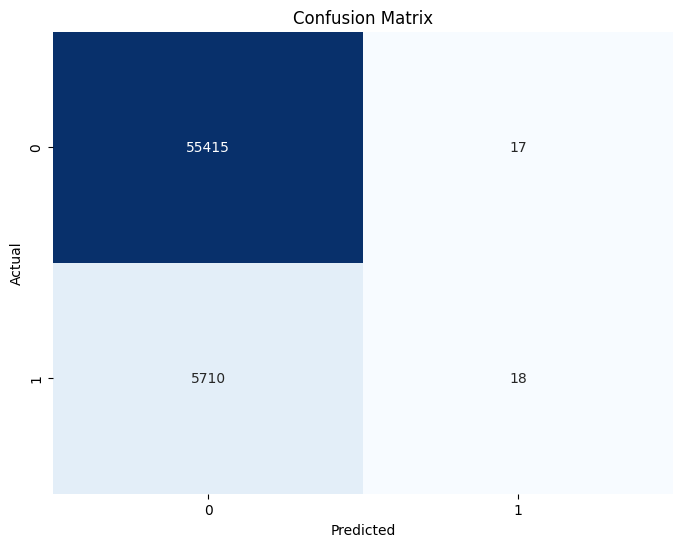

Accuracy: 0.9063603662524525


In [72]:
if experience_comet : 
    experience = Experiment(
        api_key=os.environ.get(comet_api_key),
        project_name='milestone2',
        workspace='ift6758-a02',
    )
    experience.set_name("Modèle XGBoost avec distance et angle")

# On garde que les caractéristique qu'on veut étudier ici
X_train_select = train_data[['distanceToNet', 'relativeAngleToNet']]
y_train_select = train_data['isGoal']

# Split l'ensemble de données en ensembles d'entraînement et de validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train_select, y_train_select, test_size=0.2, random_state=42)


# Initialisation du modèle XGBoost
model = xgb.XGBClassifier()

# Entraîenement
model.fit(X_train, y_train, eval_metric=["logloss"], eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=False)

# prédictions sur l'ensemble de validation
y_pred = model.predict(X_valid)

# Matrice de confusion
conf_matrix = confusion_matrix(y_valid, y_pred)
#print(f"Confusion Matrix:\n{conf_matrix}")
# Visualisation de la matrice de confusion avec Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
if experience_comet :
    plt.savefig("images/matrix_conf_XGBoost_dist_angle.png")
plt.show()

# Accuracy
accuracy = accuracy_score(y_valid, y_pred)
print(f"Accuracy: {accuracy}")

# Log Loss
#y_pred_proba = model.predict_proba(X_valid)
#logloss = log_loss(y_valid, y_pred_proba)
#print(f"Log Loss: {logloss}")

# Courbes de log-loss
#evals_result = model.evals_result()
#train_logloss = evals_result['validation_0']['logloss']
#valid_logloss = evals_result['validation_1']['logloss']
#
#plt.plot(train_logloss, label='Train')
#plt.plot(valid_logloss, label='Validation')
#plt.xlabel('Boosting Rounds')
#plt.ylabel('Log Loss')
#plt.title('XGBoost Log Loss')
#plt.legend()
#if experience_comet :
#    plt.savefig("images/log_loss_XGBoost_dist_angle.png")
#plt.show()

if experience_comet : 
    pickle.dump(model, open("models/XGBoost_dist_angle.json", "wb"))

    experience.log_model("Modèle XGBoost", "models/XGBoost_dist_angle.json")
    experience.log_confusion_matrix(y_true=y_valid, y_predicted=y_pred, title="XGBoost Confusion Matrix")
    #experience.log_curve("XGBoost train-log-loss", range(len(train_logloss)), train_logloss, step=1)
    #experience.log_curve("XGBoost valid-log-loss", range(len(valid_logloss)), valid_logloss, step=1)
    #experience.log_image("Log Loss Curve", "images/log_loss_XGBoost_dist_angle.png")
    experience.log_metric("accuracy", accuracy)
    #experience.log_metric("loss", logloss)
    experience.add_tag("XGBoost")
    experience.end()


### Figures

#### i) ROC/AUC

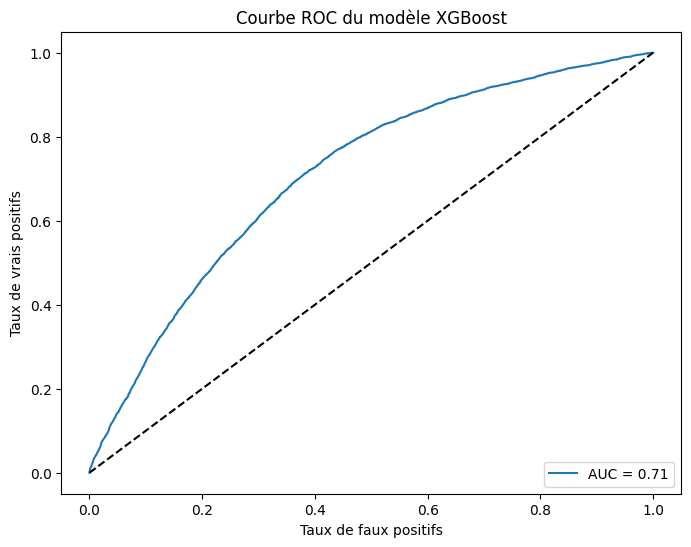

In [12]:
# prédictions sur l'ensemble de validation (proba de chaque classe)
y_prob = model.predict_proba(X_valid)[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_valid, y_prob)

# Calculer l'AUC
auc = roc_auc_score(y_valid, y_prob)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC du modèle XGBoost')
plt.legend(loc='lower right')
plt.show()

#### ii) Taux de buts vs percentile de probabilité

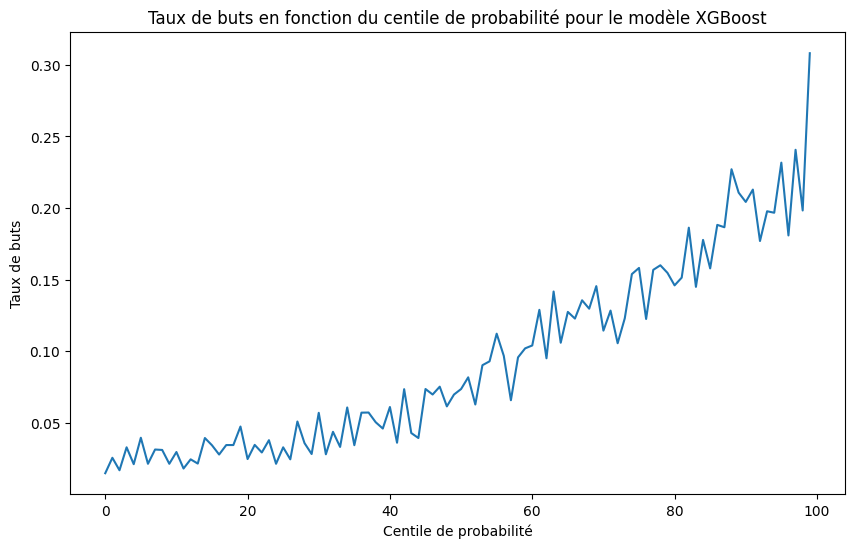

In [13]:
# Calculer les probabilités prédites
y_prob = model.predict_proba(X_valid)[:, 1]

import pandas as pd

# Créer un DataFrame avec les probabilités et les étiquettes réelles
prob_df = pd.DataFrame({'Probabilite': y_prob, 'isGoal': y_valid})

prob_df = prob_df.sort_values(by='Probabilite')

# Ajouter une colonne 'Centile' au DataFrame
prob_df['Centile'] = pd.qcut(prob_df['Probabilite'], q=100)

# Calculer le taux de buts pour chaque centile
goal_rate_by_centile = prob_df.groupby('Centile')['isGoal'].mean()


# Convertir l'index en pourcentage pour représenter le centile
percentiles = goal_rate_by_centile.index.codes / len(goal_rate_by_centile.index.categories) * 100

# Tracer le taux de buts en fonction du centile
plt.figure(figsize=(10, 6))
plt.plot(percentiles, goal_rate_by_centile.values)
plt.xlabel('Centile de probabilité')
plt.ylabel('Taux de buts')
plt.title('Taux de buts en fonction du centile de probabilité pour le modèle XGBoost')
plt.show()

#### iii) Proportion cumulée de buts vs percentile de probabilité

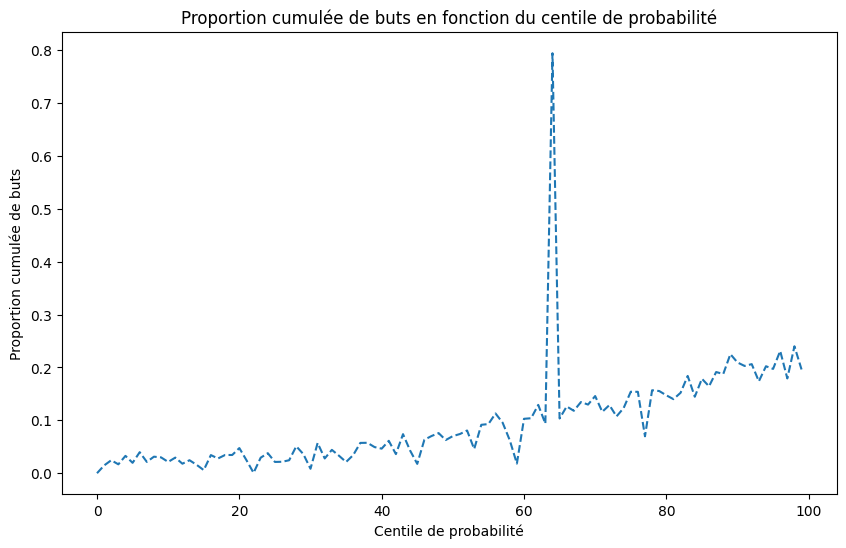

In [14]:
# Calcul des probabilités prédites
y_prob = model.predict_proba(X_valid)[:, 1]

# Création du DataFrame avec probabilités et étiquettes réelles
prob_df = pd.DataFrame({'Probabilite': y_prob, 'isGoal': y_valid})

# Tri du DataFrame par ordre croissant des probabilités
prob_df = prob_df.sort_values(by='Probabilite')

# Ajout de la colonne 'Centile' au DataFrame
prob_df['Centile'] = pd.qcut(prob_df['Probabilite'], q=100)

# Calcul du nombre cumulatif de buts et non-buts pour chaque centile
cumulative_goals = prob_df.groupby('Centile')['isGoal'].cumsum()
cumulative_shots = prob_df.groupby('Centile').cumcount() + 1

# Calcul de la proportion cumulée de buts et non-buts pour chaque centile
cumulative_goal_proportion = cumulative_goals / cumulative_shots
cumulative_non_goal_proportion = 1 - cumulative_goal_proportion

resampled_cumulative_goal_proportion = np.interp(percentiles, np.linspace(0, 100, len(cumulative_goal_proportion.values)), cumulative_goal_proportion.values)

plt.figure(figsize=(10, 6))
plt.plot(percentiles, resampled_cumulative_goal_proportion, label='Buts', linestyle='--')
plt.xlabel('Centile de probabilité')
plt.ylabel('Proportion cumulée de buts')
plt.title('Proportion cumulée de buts en fonction du centile de probabilité')
plt.show()

#### iv) Courbe de fiabilité

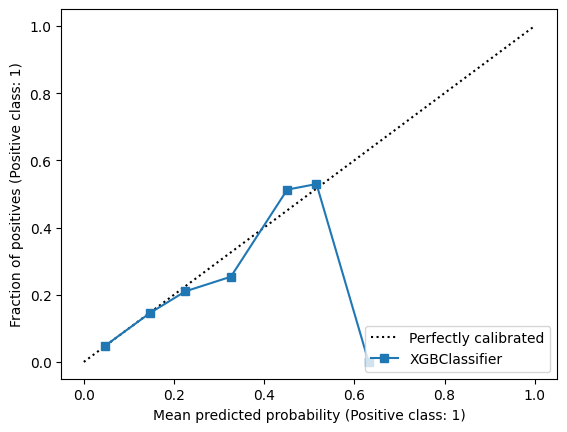

<Figure size 1000x600 with 0 Axes>

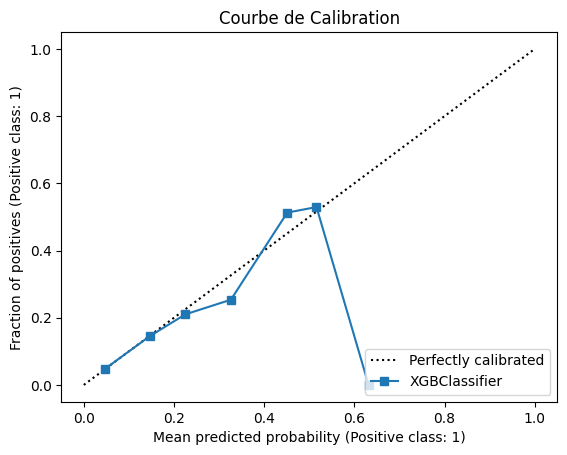

In [15]:
# Calculer les probabilités prédites
y_prob = model.predict_proba(X_valid)[:, 1]

# Obtenir la courbe de calibration
prob_true, prob_pred = calibration_curve(y_valid, y_prob, n_bins=10, strategy='uniform')

# Créer un objet CalibrationDisplay
calibration_display = CalibrationDisplay.from_estimator(model, X_valid, y_valid, n_bins=10)

# Afficher la courbe de calibration
plt.figure(figsize=(10, 6))
calibration_display.plot()
plt.title('Courbe de Calibration')
plt.show()

### 2. Classificateur XGBoost en utilisant toutes les caractéristiques créées dans la Partie 4 

In [16]:
train_data_path_2 = data_path+"\\nhl_2016to2019_previous_v2_0.csv"
test_data_path_2 = data_path+"\\nhl_data_2020_previous_v2_0.csv"

In [17]:
train_data_2=pd.read_csv(train_data_path_2)
test_data_2=pd.read_csv(test_data_path_2)

In [18]:
train_data_2.sample(3)

,period,periodTimeInSeconds,isGoal,typeDeTir,x,y,distanceToNet,relativeAngleToNet,previousEventTypeId,previousX,previousY,distanceFromPrevious,timeDiff,rebond,angleChange,vitesse,season
240747,3.0,575,0,Backhand,81.0,4.0,9.848858,1.340008,GIVEAWAY,81.0,40.0,36.00,1,False,0.0,36.000000,2019
166633,2.0,893,0,Wrist Shot,-79.0,-36.0,37.643060,-73.009177,MISSED_SHOT,-78.0,10.0,46.01,39,False,0.0,1.179744,2018
131132,2.0,225,0,Deflected,-73.0,6.0,18.027756,19.440035,MISSED_SHOT,75.0,-21.0,150.44,10,False,0.0,15.044000,2017


In [19]:
print(train_data_2.shape)
print(test_data_2.shape)

(305797, 17)
(52408, 17)


On vérifie s'il y a des NaN et on enlève les lignes correspondantes si c'est le cas.

In [20]:
# Vérifier s'il y a des NaN dans tout le DataFrame
nan_check = train_data_2.isna().any().any()

# Afficher le résultat
print(f"Y a-t-il des NaN dans le DataFrame ? {nan_check}")

# Vérifier s'il y a des NaN dans chaque colonne
nan_columns = train_data_2.columns[train_data_2.isna().any()]

# Afficher les colonnes avec des NaN
if not nan_columns.empty:
    print(f"Colonnes avec des NaN : {nan_columns}")
else:
    print("Aucune colonne avec NaN.")


Y a-t-il des NaN dans le DataFrame ? True
Colonnes avec des NaN : Index(['typeDeTir', 'previousX', 'previousY', 'distanceFromPrevious',
       'angleChange', 'vitesse'],
      dtype='object')


In [21]:
train_data_2.dropna(inplace=True)

Pareil pour les valeurs infinies

In [22]:
# Calculer la proportion de valeurs infinies dans le dataframe
inf_proportion = train_data_2.replace([np.inf, -np.inf], np.nan).isna().mean().mean()

# Afficher le nombre total de lignes dans le dataframe
num_rows = len(train_data_2)

print(f"Proportion de valeurs infinies : {inf_proportion:.2%}")
print(f"Nombre total de lignes dans le dataframe : {num_rows}")


Proportion de valeurs infinies : 0.11%
Nombre total de lignes dans le dataframe : 301594


Au vu de la proportion de valeurs infinies et de la taille des données, on préfère simplement supprimer ces lignes correspondantes plutot que de les modifier en faisant une moyenne sur toutes la colonnes par exemple

In [23]:
train_data_2 = train_data_2.replace([np.inf, -np.inf], np.nan).dropna()

Comme on doit utiliser toutes les caractéristiques, on doit vérifier qu'elles sont dans le bon format pour un entraînement

In [24]:
train_data_2.dtypes

period                  float64
periodTimeInSeconds       int64
isGoal                    int64
typeDeTir                object
x                       float64
y                       float64
distanceToNet           float64
relativeAngleToNet      float64
previousEventTypeId      object
previousX               float64
previousY               float64
distanceFromPrevious    float64
timeDiff                  int64
rebond                     bool
angleChange             float64
vitesse                 float64
season                    int64
dtype: object

Ici, certaines caractéristiques vont poser problème si on ne les modifie pas (ex : typeDeTir et previousEventTypeId), on va alors créer plus de caractéristiques comme typeDeTir_Backhand avec des valeurs à 0 ou 1 si le type du tir est 'backhand' ou non.

In [25]:
dummy_object = pd.get_dummies(train_data_2[['typeDeTir', 'previousEventTypeId']])
data = train_data_2.merge(dummy_object, left_index=True, right_index=True)
train_data_2_correct = data.drop(labels = ['typeDeTir', 'previousEventTypeId'], axis = 1)

In [26]:
train_data_2_correct.dtypes

period                              float64
periodTimeInSeconds                   int64
isGoal                                int64
x                                   float64
y                                   float64
distanceToNet                       float64
relativeAngleToNet                  float64
previousX                           float64
previousY                           float64
distanceFromPrevious                float64
timeDiff                              int64
rebond                                 bool
angleChange                         float64
vitesse                             float64
season                                int64
typeDeTir_Backhand                     bool
typeDeTir_Deflected                    bool
typeDeTir_Slap Shot                    bool
typeDeTir_Snap Shot                    bool
typeDeTir_Tip-In                       bool
typeDeTir_Wrap-around                  bool
typeDeTir_Wrist Shot                   bool
previousEventTypeId_BLOCKED_SHOT

#### Création du modèle XGBoost avec toutes les caractéristiques et son évaluation

In [27]:
# on garde que les caractéristique qu'on veut étudier ici
X_train_select_2 = train_data_2_correct.drop('isGoal', axis=1)
y_train_select_2 = train_data_2_correct['isGoal']

# split l'ensemble de données en ensembles d'entraînement et de validation
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(X_train_select_2, y_train_select_2, test_size=0.2, random_state=42)

# Initialisation du modèle XGBoost
model_2 = xgb.XGBClassifier()

# entraîenement
model_2.fit(X_train_2, y_train_2)

# prédictions sur l'ensemble de validation
y_pred_2 = model_2.predict(X_valid_2)

# accuracy
accuracy_2 = accuracy_score(y_valid_2, y_pred_2)
print(f"Accuracy: {accuracy_2}")


Accuracy: 0.908945012247656


In [69]:
experience_comet = True

c:\Users\Prevot\anaconda3\envs\ift6758\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


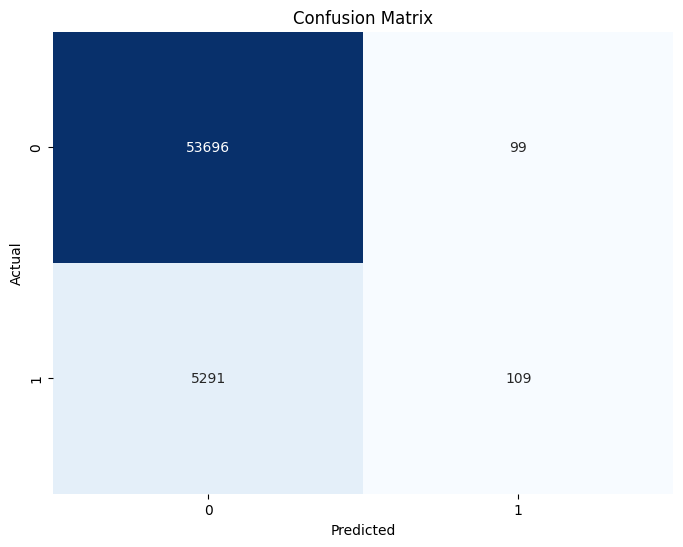

Accuracy: 0.908945012247656


In [73]:
if experience_comet : 
    experience = Experiment(
        api_key=os.environ.get(comet_api_key),
        project_name='milestone2',
        workspace='ift6758-a02',
    )
    experience.set_name("XGBoost model all features")

# on garde que les caractéristique qu'on veut étudier ici
X_train_select = train_data_2_correct.drop('isGoal', axis=1)
y_train_select = train_data_2_correct['isGoal']

# split l'ensemble de données en ensembles d'entraînement et de validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train_select, y_train_select, test_size=0.2, random_state=42)

# Initialisation du modèle XGBoost
model = xgb.XGBClassifier()

# Entraîenement
model.fit(X_train, y_train, eval_metric=["logloss"], eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=False)

# prédictions sur l'ensemble de validation
y_pred = model.predict(X_valid)

# Matrice de confusion
conf_matrix = confusion_matrix(y_valid, y_pred)
#print(f"Confusion Matrix:\n{conf_matrix}")
# Visualisation de la matrice de confusion avec Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
if experience_comet :
    plt.savefig("images/matrix_conf_XGBoost_all_features.png")
plt.show()

# Accuracy
accuracy = accuracy_score(y_valid, y_pred)
print(f"Accuracy: {accuracy}")

# Log Loss
#y_pred_proba = model.predict_proba(X_valid)
#logloss = log_loss(y_valid, y_pred_proba)
#print(f"Log Loss: {logloss}")
#
## Courbes de log-loss
#evals_result = model.evals_result()
#train_logloss = evals_result['validation_0']['logloss']
#valid_logloss = evals_result['validation_1']['logloss']
#
#plt.plot(train_logloss, label='Train')
#plt.plot(valid_logloss, label='Validation')
#plt.xlabel('Boosting Rounds')
#plt.ylabel('Log Loss')
#plt.title('XGBoost Log Loss')
#plt.legend()
#if experience_comet :
#    plt.savefig("images/log_loss_XGBoost_all_features.png")
#plt.show()

if experience_comet : 

    pickle.dump(model, open("models/XGBoost_all_features.json", "wb"))

    experience.log_model("Modèle XGBoost", "models/XGBoost_all_features.json")
    experience.log_confusion_matrix(y_true=y_valid, y_predicted=y_pred, title="XGBoost Confusion Matrix")
    #experience.log_curve("XGBoost train-log-loss", range(len(train_logloss)), train_logloss, step=1)
    #experience.log_curve("XGBoost valid-log-loss", range(len(valid_logloss)), valid_logloss, step=1)
    #experience.log_image("Log Loss Curve", "images/log_loss_XGBoost_dist_angle.png")
    experience.log_metric("accuracy", accuracy)
    #experience.log_metric("loss", logloss)
    experience.add_tag("XGBoost")

    experience.end()


#### Recherche des meilleurs hyperparamètres pour ce modèle avec toutes les caractéristiques

In [29]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Définir l'espace des hyperparamètres que vous souhaitez explorer
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Initialiser le modèle XGBoost
model = xgb.XGBClassifier()

# Initialiser la recherche par grille avec validation croisée
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)

# Entraîner la recherche par grille sur l'ensemble d'entraînement
grid_search.fit(X_train_2, y_train_2)

# Afficher les meilleurs hyperparamètres et la meilleure performance
print("Meilleurs hyperparamètres : ", grid_search.best_params_)
print("Meilleure performance (accuracy) : ", grid_search.best_score_)

Meilleurs hyperparamètres :  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 1.0}
Meilleure performance (accuracy) :  0.90910050658641


Meilleurs hyperparamètres :  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 1.0}

Meilleure performance (accuracy) :  0.90910050658641

In [78]:
experience_comet = False

In [79]:
if experience_comet : 
    experience = Experiment(
        api_key=os.environ.get(comet_api_key),
        project_name='milestone2',
        workspace='ift6758-a02',
    )
    experience.set_name("XGBoost model all features with best hyperparameters")

# Utiliser le modèle avec les meilleurs hyperparamètres pour faire des prédictions sur l'ensemble de validation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_valid)

# Afficher l'accuracy du modèle avec les meilleurs hyperparamètres sur l'ensemble de validation
best_accuracy = accuracy_score(y_valid, y_pred)
print(f"Accuracy avec meilleurs hyperparamètres : {accuracy}")


# calculés ci-dessous
best_hyperparameters = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 1.0}

if experience_comet : 

    pickle.dump(model, open("models/best_XGBoost_all_features.json", "wb"))

    experience.log_model("best XGBoost model", "models/best_XGBoost_all_features.json")
    experience.log_confusion_matrix(y_true=y_valid, y_predicted=y_pred, title="best XGBoost Confusion Matrix")
    experience.log_parameters(best_hyperparameters)
    experience.log_metric("best accuracy", best_accuracy)
    experience.add_tag("XGBoost")

    experience.end()

Accuracy avec meilleurs hyperparamètres : 0.9093673452149674
